In [1]:
#%env CUDA_VISIBLE_DEVICES=2

In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
import os

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3,4"
#os.environ['WORLD_SIZE'] = "2"
#os.environ['RANK'] = "0"

In [5]:
!env

EG_IMPERSONATION_ENABLED=False
MPLBACKEND=module://matplotlib_inline.backend_inline
PAGER=cat
LC_CTYPE=C.UTF-8
KERNEL_USERNAME=guest
KERNEL_GATEWAY=1
KERNEL_ID=6674600a-931c-4677-848b-328eab277f5a
CUDA_VISIBLE_DEVICES=2,3,4
TERM=xterm-color
PATH=/opt/conda/bin:/usr/local/mpi/bin:/usr/local/nvidia/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
KERNEL_LANGUAGE=python
KERNEL_LAUNCH_TIMEOUT=40
GIT_PAGER=cat
KERNEL_WORKING_DIR=C:\Users\mohor\Jupyter\quantum-drug-generator\ReLeaSE-multiobjective
CLICOLOR=1
PWD=/workspace
JPY_PARENT_PID=21


In [6]:
import sys

In [7]:
sys.path.append('./release/')

In [8]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
cd /workspace/projects/quantum-drug-generator/ReLeaSE-multiobjective/release

/workspace/projects/quantum-drug-generator/ReLeaSE-multiobjective/release


In [10]:
use_cuda = torch.cuda.is_available()

In [11]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import Descriptors
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

In [12]:
#!pip install tdqm rdkit sklearn seaborn

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Generator

In [14]:
cd /workspace/projects/quantum-drug-generator/ReLeaSE-multiobjective/data

/workspace/projects/quantum-drug-generator/ReLeaSE-multiobjective/data


In [15]:
gen_data_path = 'logP_red_3.smi'

In [16]:
#tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
#          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
#          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

#tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
#          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
#          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n', 'Y']

#tokens = ["<", ">", "0", "1", "2", "3", "4", "5", "6", "#", "=", "[", "]", "e",
#          "(", ")", "H", "C", "N", "O", "P", "S", "a", "F", "l", "B", "r", "I", "+", "-","/","\\", "i", "."]

tokens = ["<", ">", "0", "1", "2", "3", "4", "#", "=", "[", "]", 
         "(", ")", "H", "C", "N", "O", "P", "S", "a", "F", "l", "B", "r", "I", "Y"]


In [17]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',', 
                         cols_to_read=[0], keep_header=True, tokens=tokens, pad_symbol='Y')

#gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
#                         cols_to_read=[0], keep_header=True, tokens=tokens, use_cuda=use_cuda, pad_symbol='Y')

In [18]:
gen_data.random_training_set(10);

In [19]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'QGRU'
lr = 0.03
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr, ignore_idx = gen_data.pad_symbol_idx,
                                 device_update="cuda:0",
                                 device_reset="cuda:1",
                                 device_memory="cuda:2",
                                 backend = "lightning.gpu", n_qubits = 3 )

Backend:  lightning.gpu
weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 3)


In [20]:
# my_generator = torch.nn.DataParallel(my_generator)

In [21]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [22]:
#import cProfile

In [23]:
#cProfile.run("my_generator.fit(gen_data, 20, 10)")

In [24]:
losses = my_generator.fit(gen_data, 20, 10)

Training in progress...:   0%|          | 0/10 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument mat1 in method wrapper_addmm)

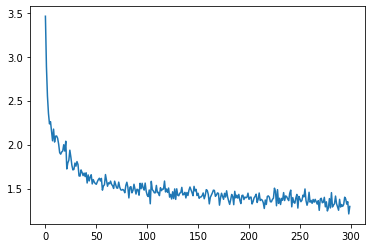

In [21]:
plt.plot(losses)

In [22]:
#my_generator.save_model(model_path)

In [23]:
#my_generator.load_model(model_path)

In [24]:
n_generate = 100
batch_s = 10

def estimate(generator, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, batch_size = batch_s))
        
    return generated

def clean_generated(gen):
    gen_size = len(gen)
    batch_size = len(gen[0])
    
    gen_clean = []
    
    for i in range(gen_size):
        new = []
        for j in range(batch_size):
            new.append(gen[i][j][1:-1])
        gen_clean.append(new)
    
    return gen_clean
            

In [25]:
gen = estimate(my_generator, n_to_generate = n_generate)

Generating molecules...: 100%|██████████| 100/100 [33:21<00:00, 20.02s/it]


In [26]:
new_san = []

for i in range(n_generate):
    sanitized = canonical_smiles(clean_generated(gen)[i], sanitize=False, throw_warning=False)
    for j in range(batch_s):
        if sanitized[j] != '':
            new_san.append(sanitized[j])
             
new_san

[04:43:36] SMILES Parse Error: unclosed ring for input: 'CC1=CC1(C)NC1'
[04:43:36] SMILES Parse Error: unclosed ring for input: 'C(C)=C#C=N1'
[04:43:36] SMILES Parse Error: syntax error while parsing: CC(F==O)O)CO1
[04:43:36] SMILES Parse Error: Failed parsing SMILES 'CC(F==O)O)CO1' for input: 'CC(F==O)O)CO1'
[04:43:36] SMILES Parse Error: syntax error while parsing: =SO(C)C(O)(C)CP(C)C1
[04:43:36] SMILES Parse Error: Failed parsing SMILES '=SO(C)C(O)(C)CP(C)C1' for input: '=SO(C)C(O)(C)CP(C)C1'
[04:43:36] SMILES Parse Error: unclosed ring for input: 'CCCOC(C=O)CC2CC(C=O)CN1'
[04:43:36] SMILES Parse Error: unclosed ring for input: 'CO=CC1'
[04:43:36] SMILES Parse Error: syntax error while parsing: ClC(=N()CC=CCl
[04:43:36] SMILES Parse Error: Failed parsing SMILES 'ClC(=N()CC=CCl' for input: 'ClC(=N()CC=CCl'
[04:43:36] SMILES Parse Error: unclosed ring for input: 'NC2=CC=C1'
[04:43:36] SMILES Parse Error: unclosed ring for input: 'NSO(C)=N1'
[04:43:36] SMILES Parse Error: syntax error 

['CO',
 'C=CCCCC=NC(C)O',
 'CC#O',
 'CC1=C=C1',
 'OC=C1CCCCCCC=CN1',
 'CNCC1=CCC=CC(O)=C=C1',
 'C=C1CC=CCCC1',
 'CN(O)O',
 'N=[SH]OO1=CC=CC1',
 'CCC1C=C=CCCC=N1',
 'CC=N1C=C=C1',
 'CCC1=C=CCC=C=C1',
 'CSC(C)C1(O)=CC=C1',
 'NCCOC(C=O)CN',
 'CC=CC1C=CC=CC1',
 'CCCCC1=C=C1',
 'CCCl',
 'O=N(S)NC1=CC1',
 'CC=CC1CC1',
 'C=C=C1C=CC=OC1',
 'N=CC(CN)O(N)CF',
 'CCCC=C=O',
 'CC=Cl',
 'CCCC',
 'C=OCC=CC',
 'CCN1=O=N1C',
 'CCC1=CC=CN1',
 'CCCCC=CSBr',
 'C1#CCCN=C1',
 'CC(O)CCC1=O=CN1',
 'CNC=C(C)C',
 'O=CC(O)CCI',
 'BCC(C)=N',
 'CCN1CCC(=O)OC=CC(C)C1',
 'O=C(O)CF',
 'CCCPN',
 'CC1CCCCOCCC1',
 'COC(C)C=CC(C)N',
 'SC1=CC=C=C1',
 'O=CF',
 'C=CCC',
 'CNC(C)O',
 'CC',
 'OCC1=C=N=NCC=CC1',
 'CCO',
 'NNC(C=O)CO(O)Cl',
 'CCF',
 'C=CC1CCN=C(C)CN=NCCN(=O)C1C',
 'C=C(N)CCC=CCC',
 'CCC(C=O)C=C1=C=C1',
 'CC1C=CCCCCCC1',
 'CCC(O)F',
 'CCC=CNF',
 'C=CCC#O',
 'CNCNCN1=CC1',
 'CC(C=O)CCCl',
 'OCCCCCC1=C(Cl)N=C1',
 'CC=CCC(O)O',
 'CNC=C#C1C=C=N1',
 'OC=CCCCN1C=C=CC1',
 'CC=CCC=Cl',
 'CPNCl',
 'CC=NC1=CC(=CCCCC)CC(C)

In [27]:
len(new_san)

382

In [28]:
len(new_san)/(n_generate * batch_s)

0.382

In [29]:
gen_mol_weight = []
for i in new_san:
    mol = Chem.MolFromSmiles(i)
    if mol != None:
        molwt = Descriptors.ExactMolWt(mol)
        gen_mol_weight.append(molwt)
gen_mol_weight

[04:43:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[04:43:37] Explicit valence for atom # 3 O, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 2 N, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[04:43:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 6 O, 3, is greater than permitted
[04:43:37] Explicit valence for atom # 5 O, 3, is greater than permitted
[04:43:37] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[04:43:37] Explicit valence for atom # 1 O, 3, is greater than permitted
[04:43:37] Explicit valence for atom # 2 N, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 6 O, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 4 N, 4, is greater than permitted
[04:43:37] Explicit valence for atom # 6 O, 3, is greater than permitted
[04:43:37] Explicit valence for atom # 13 N, 4, is

[32.026214748,
 141.1153641,
 52.031300128,
 167.131014164,
 163.099714036,
 108.093900384,
 63.0320284,
 135.104799416,
 118.07825032,
 132.089877624,
 120.093900384,
 94.07825032,
 64.00797784,
 82.07825032,
 84.057514876,
 58.078250319999995,
 95.073499288,
 193.976483452,
 79.04219916,
 85.08914935199999,
 213.949077464,
 69.074979656,
 183.125928784,
 78.011707556,
 91.05508594999999,
 142.135765196,
 129.1153641,
 96.003371128,
 48.001142872,
 56.062600255999996,
 75.068413908,
 30.046950192,
 46.041864812,
 48.03752838,
 125.12044947999999,
 138.140850576,
 78.048093064,
 89.064077476,
 120.034192588,
 173.060741684,
 102.06807956,
 151.099714036,
 96.98481346999999,
 219.19869979999999,
 123.10479941599999,
 203.989825008,
 100.12520051199999,
 30.046950192,
 46.041864812,
 284.10170526,
 126.07931294,
 56.079730688,
 45.057849223999995,
 60.021129368000004,
 88.088815004,
 114.06807956,
 123.02510512399999,
 82.053098192,
 97.08914935199999,
 82.041864812,
 202.03571258,
 116.

(array([22., 55., 71., 49., 35., 14.,  7.,  3.,  0.,  2.]),
 array([ 16.03130013,  45.03409978,  74.03689942, 103.03969907,
        132.04249872, 161.04529837, 190.04809802, 219.05089766,
        248.05369731, 277.05649696, 306.05929661]),
 <BarContainer object of 10 artists>)

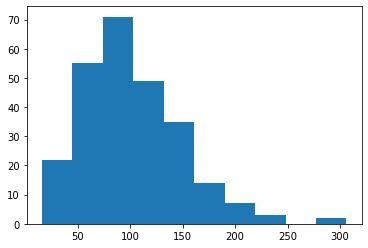

In [30]:
plt.hist(gen_mol_weight)

In [31]:
lower_weight = np.percentile(gen_mol_weight, 80)

In [32]:
upper_weight =np.percentile(gen_mol_weight, 100)

# Predictor

In [ ]:
ls

In [ ]:
cd /workspace/projects/quantum-drug-generator/ReLeaSE-multiobjective

In [ ]:
!pip install openchem

In [ ]:
import os
import torch
from sklearn.metrics import r2_score
from modules.smiles import *
from release.predictor_logp import Predictor

In [ ]:
kwargs = {}

path_to_model = 'models/model_best_test.pt'
#path_to_model = 'models/model_best_train.pt'
#path_to_model = 'models/model.pt'
path_to_dictionary = 'data/Dictionary'

predictor = torch.load(path_to_model)

In [ ]:
predictor_tokens = tokens + [' ']

In [ ]:
my_predictor = Predictor(predictor, predictor_tokens)

In [ ]:
my_predictor.predict(['OS','O','CC','NCl=C','CBCN'])

In [ ]:
Chem.MolToSmiles(Chem.MolFromSmiles('CBCN'), kekuleSmiles=True)

# RL

In [ ]:
from reinforcement import Reinforcement

In [ ]:
def plot_hist(smiles, prediction, n_to_generate, batch_size):
    prediction = prediction.detach().numpy()
    percentage_in_threshold = np.sum((prediction >= 1.0) & 
                                     (prediction <= 4.0))/len(prediction)
    
    gen_mol_weight = []
    for i in smiles:
        mol = Chem.MolFromSmiles(i)
        if mol != None:
            molwt = Descriptors.ExactMolWt(mol)
            gen_mol_weight.append(molwt)
    mean = np.percentile(gen_mol_weight, 50)
    
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/ (n_to_generate * batch_size))
    print("Average Mol Weight:", mean)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()
    
    return percentage_in_threshold, mean

In [ ]:
def estimate_and_update(generator, predictor, n_to_generate, batch_size):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, batch_size = batch_size))
        
    new_san = []

    for i in range(n_to_generate):
        sanitized = canonical_smiles(clean_generated(generated)[i], sanitize=False, throw_warning=False)
        for j in range(batch_size):
            if sanitized[j] != '':
                new_san.append(sanitized[j])

    new_san

    #sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(new_san))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    p, w = plot_hist(smiles, torch.FloatTensor(prediction), n_to_generate, batch_size)
        
    return smiles, prediction, p, w 

In [ ]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr, ignore_idx = gen_data.pad_symbol_idx)

my_generator_max.load_model(model_path)

In [ ]:
# Setting up some parameters for the experiment
n_to_generate = 100
n_policy_replay = 10
n_policy = 15
n_iterations = 20

n_generate = 100
batch_s = 10

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [ ]:
def get_weight_reward(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is not None:
        molwt = Descriptors.ExactMolWt(mol)
        if lower_weight <= molwt < upper_weight:
            return 1
        else:
            return 0
    else:
        return 0

In [ ]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    good_weight = get_weight_reward(smiles)
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0) and good_weight == 1:
        return 11.0
    else:
        return 1.0

In [ ]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

In [ ]:
smiles_unbiased, prediction_unbiased, _ , _ = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=n_to_generate,
                                                           batch_size = batch_s)

In [ ]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [ ]:
rewards = []
rl_losses = []

In [ ]:
smiles_unbiased

In [ ]:
prediction_unbiased

In [ ]:
percentage = []
avg_weight = []

for i in range(n_iterations):
    print('Policy Iteration:', i)
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
    
    
    
    smiles_cur, prediction_cur, p, w = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate,
                                                     batch_s)
    
    percentage.append(p)
    avg_weight.append(w)
    
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

In [ ]:
smiles_cur

In [ ]:
percentage

In [ ]:
avg_weight